# Kenya Clinical Reasoning Challenge

This notebook explores and builds a model for the Kenya Clinical Reasoning Challenge, which focuses on predicting clinician responses to medical scenarios in rural Kenyan healthcare settings.

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Data Loading

Let's load the training and testing datasets to begin our analysis.

In [2]:
# Load the train and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Also load the raw versions which may contain additional information
train_raw_df = pd.read_csv('train_raw.csv')
test_raw_df = pd.read_csv('test_raw.csv')

print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

Train dataset shape: (400, 12)
Test dataset shape: (100, 7)


## Data Exploration

Let's examine the structure of our datasets and understand the clinical scenarios better.

In [3]:
# Display the first few rows of the training data
train_df.head()

,Master_Index,County,Health level,Years of Experience,Prompt,Nursing Competency,Clinical Panel,Clinician,GPT4.0,LLAMA,GEMINI,DDX SNOMED
0,ID_VBWWP,uasin gishu,sub county hospitals and nursing homes,18.0,i am a nurse with 18 years of experience in ge...,pediatric emergency burns,surgery,summary a 4 year old with 5 superficial burns ...,given your vast experience as a nurse in uasin...,1 immediate treatment protocol for second degr...,here s a response addressing the questions reg...,288514009 burn involving 5 percent of body sur...
1,ID_XMBBY,uasin gishu,national referral hospitals,17.0,i am a nurse with 17 years of experience in ge...,child health,paediatrics,summary 6 year old present with vomiting and a...,clinical summary • a 6 year old girl with know...,based on the symptoms and signs you ve describ...,based on the presentation the 6 year old girl ...,420270002 ketoacidosis due to type 1 diabetes ...
2,ID_JZNZW,kiambu,sub county hospitals and nursing homes,12.0,i am a nurse with 12 years of experience in ge...,general emergency,internal medicine,summary a 47 year old man presents with severe...,in this case you re dealing with a 47 year old...,firstly i must commend you on your thorough hi...,this 47 year old male presenting with severe r...,13200003 peptic ulcer disorder 25458004 acute ...
3,ID_QOQTK,uasin gishu,national referral hospitals,12.0,i am a nurse with 12 years of experience in pr...,critical care,internal medicine,summary 72 year old female with inability to w...,given er s clinical presentation and vitals th...,to me with this query based on the information...,this 92 year old female patient er presents wi...,14760008 constipation finding 419284004 altere...
4,ID_ZFJBM,uasin gishu,national referral hospitals,16.0,i am a nurse with 16 years of experience in ge...,adult health,internal medicine,a 22 year old female presents with headache di...,the 22 year old female patient is presenting w...,thank you for presenting this case based on th...,this 22 year old female patient presents with ...,95874006 carbon monoxide poisoning from fire d...


In [4]:
# Check for columns in the training set
print("Train dataset columns:")
print(train_df.columns.tolist())

print("\nTest dataset columns:")
print(test_df.columns.tolist())

Train dataset columns:
['Master_Index', 'County', 'Health level', 'Years of Experience', 'Prompt', 'Nursing Competency', 'Clinical Panel', 'Clinician', 'GPT4.0', 'LLAMA', 'GEMINI', 'DDX SNOMED']

Test dataset columns:
['Master_Index', 'County', 'Health level', 'Years of Experience', 'Prompt', 'Nursing Competency', 'Clinical Panel']


In [5]:
# Check for missing values
print("Missing values in train dataset:")
print(train_df.isnull().sum())

print("\nMissing values in test dataset:")
print(test_df.isnull().sum())

Missing values in train dataset:
Master_Index             0
County                   0
Health level             0
Years of Experience    100
Prompt                   0
Nursing Competency       0
Clinical Panel           0
Clinician                0
GPT4.0                   0
LLAMA                    0
GEMINI                   0
DDX SNOMED               1
dtype: int64

Missing values in test dataset:
Master_Index            0
County                  0
Health level            0
Years of Experience    25
Prompt                  0
Nursing Competency      0
Clinical Panel          0
dtype: int64


## Data Preprocessing

Based on the challenge description, we need to transform the clinician responses according to specific rules:
1. Deal with missing values
2. Convert all text to lowercase
3. Remove punctuation
4. Replace paragraphs with spaces

In [6]:
# Dealing with missing values
# Years of experience column has some missing values, let's fill them with the mean
train_df['Years of Experience'].fillna(train_df['Years of Experience'].mean(), inplace=True)    
test_df['Years of Experience'].fillna(test_df['Years of Experience'].mean(), inplace=True)

# DDX SNOMED column has some missing values, let's fill them with the mode
train_df['DDX SNOMED'].fillna(train_df['DDX SNOMED'].mode()[0], inplace=True)

# Clean up the 'Clinician' column by removing the "summary" prefix
def clean_summary_prefix(text):
    """Remove 'summary' and redundant text from the beginning of clinician responses"""
    if pd.isna(text):
        return text
    
    # Check if the text starts with 'summary'
    text = text.lower().strip()
    if text.startswith('summary'):
        # Find where the actual content begins after the case summary
        # Typically after details about the patient, symptoms, vitals, etc.
        
        # Look for common transition points where the actual medical advice begins
        content_markers = [
            'diagnosis:', 'diagnosis', 'management:', 'management',
            'treatment:', 'treatment', 'plan:', 'plan',
            'investigations:', 'investigations', 'ddx', 'differentials:',
            'immediate management', 'how to manage'
        ]
        
        # First, try to find the position of any content markers
        positions = [text.find(marker) for marker in content_markers if text.find(marker) > 0]
        
        if positions:
            # Find the earliest marker position
            start_pos = min(positions)
            return text[start_pos:].strip()
        else:
            # If no marker is found, check for end of patient description
            # This typically contains age, vitals, symptoms in the summary
            # Often ends with phrases like 'vitals are normal', 'temp', 'bp', etc.
            vital_markers = ['vitals', 'bp', 'temp', 'pulse', 'spo2', 'vital signs']
            vital_positions = []
            
            # Find the last mention of vitals
            for marker in vital_markers:
                pos = text.rfind(marker, 0, len(text)//2)  # Search in the first half
                if pos > 0:
                    vital_positions.append(pos)
            
            if vital_positions:
                # Find where the vital signs description likely ends
                vital_pos = max(vital_positions)
                end_of_vitals = text.find('.', vital_pos)
                if end_of_vitals > 0:
                    return text[end_of_vitals + 1:].strip()
            
            # Last resort: look for a question that might start the clinical response
            questions = ['what ', 'how ', 'why ', 'when ', 'which ', 'is ', 'are ', 'can ', 'should ']
            for q in questions:
                q_pos = text.find(q, len('summary') + 5)  # Search after 'summary' + some buffer
                if q_pos > 0:
                    # Find the beginning of the sentence containing the question
                    sentence_start = text.rfind('. ', 0, q_pos)
                    if sentence_start > 0:
                        return text[sentence_start + 2:].strip()
                    else:
                        return text[q_pos:].strip()
            
            # If all else fails, just remove 'summary' and a bit after it
            return text[len('summary') + 2:].strip()
    
    return text

# Apply the cleaning function to the Clinician column
print("Sample clinician column before cleaning:")
print(train_df['Clinician'].iloc[0])
print("\n---\n")

train_df['Clinician'] = train_df['Clinician'].apply(clean_summary_prefix)

print("Sample clinician column after cleaning:")
print(train_df['Clinician'].iloc[0])
print("\n---\n")

# Check how many rows had the 'summary' prefix
original_texts = pd.read_csv('train.csv')['Clinician']
summary_count = sum(1 for text in original_texts if str(text).lower().strip().startswith('summary'))
print(f"Number of clinician responses that started with 'summary': {summary_count} out of {len(train_df)}")

Sample clinician column before cleaning:
summary a 4 year old with 5 superficial burns no other injuries immediate management paracetamol analgesics to to ensure child has minimal or no pain cleaning and frosting of wound with silver sulpha fizika topical prophylactic can be considered in this case good nutrition high protein diet

---

Sample clinician column after cleaning:
immediate management paracetamol analgesics to to ensure child has minimal or no pain cleaning and frosting of wound with silver sulpha fizika topical prophylactic can be considered in this case good nutrition high protein diet

---



Number of clinician responses that started with 'summary': 316 out of 400


In [7]:
# Check for duplicates
print("Duplicate rows in train dataset:")
print(train_df.duplicated().sum())

print("\nDuplicate rows in test dataset:")
print(test_df.duplicated().sum())

Duplicate rows in train dataset:
0

Duplicate rows in test dataset:
0


## Feature Engineering

Let's create features that will help our model understand the clinical scenarios better.

In [9]:
import re
!pip install -q nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Download necessary NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("NLTK resources downloaded successfully")
except Exception as e:
    print(f"Error downloading NLTK resources: {e}")

# 1. Create nurse experience/seniority categories
def categorize_experience(years):
    """Categorize years of experience into seniority levels."""
    if years < 5:
        return 'Junior'
    elif years < 10:
        return 'Intermediate'
    elif years < 15:
        return 'Senior'
    else:
        return 'Expert'

# Apply to both datasets
train_df['Experience_Level'] = train_df['Years of Experience'].apply(categorize_experience)
test_df['Experience_Level'] = test_df['Years of Experience'].apply(categorize_experience)

# 2. Extract patient demographics from prompts
def extract_patient_demographics(text):
    """Extract patient age, gender, and other key demographics from prompt text."""
    demographics = {}
    
    # Extract age
    age_pattern = r'(\d+)[ -](?:year|yr)[ -]old'
    age_match = re.search(age_pattern, text.lower())
    if age_match:
        demographics['age'] = int(age_match.group(1))
    else:
        demographics['age'] = None
    
    # Extract gender
    if re.search(r'\b(male|man|boy|he|him)\b', text.lower()):
        demographics['gender'] = 'Male'
    elif re.search(r'\b(female|woman|girl|she|her)\b', text.lower()):
        demographics['gender'] = 'Female'
    else:
        demographics['gender'] = 'Unknown'
    
    # Pediatric vs Adult
    demographics['is_pediatric'] = False
    if 'age' in demographics and demographics['age'] is not None:
        if demographics['age'] < 18:
            demographics['is_pediatric'] = True
    elif re.search(r'\b(child|infant|baby|toddler|newborn)\b', text.lower()):
        demographics['is_pediatric'] = True
    
    # Extract if emergency
    demographics['is_emergency'] = bool(re.search(r'\b(emergency|urgent|critical|immediately|collapse)\b', text.lower()))
    
    return demographics

# Apply to both datasets
train_demographics = train_df['Prompt'].apply(extract_patient_demographics)
test_demographics = test_df['Prompt'].apply(extract_patient_demographics)

# Convert the dictionaries to dataframe columns
train_df['Patient_Age'] = train_demographics.apply(lambda x: x['age'])
train_df['Patient_Gender'] = train_demographics.apply(lambda x: x['gender'])
train_df['Is_Pediatric'] = train_demographics.apply(lambda x: x['is_pediatric'])
train_df['Is_Emergency'] = train_demographics.apply(lambda x: x['is_emergency'])

test_df['Patient_Age'] = test_demographics.apply(lambda x: x['age'])
test_df['Patient_Gender'] = test_demographics.apply(lambda x: x['gender'])
test_df['Is_Pediatric'] = test_demographics.apply(lambda x: x['is_pediatric'])
test_df['Is_Emergency'] = test_demographics.apply(lambda x: x['is_emergency'])

# 3. Extract symptoms and conditions (medical NLP features)
def extract_medical_keywords(text):
    """Extract key medical terms from the prompt."""
    # Common symptoms and conditions to look for
    keywords = [
        'fever', 'pain', 'cough', 'headache', 'nausea', 'vomiting', 'diarrhea',
        'bleeding', 'swelling', 'rash', 'fatigue', 'weakness', 'difficulty breathing',
        'hypertension', 'diabetes', 'asthma', 'hiv', 'tuberculosis', 'malaria',
        'pneumonia', 'wound', 'injury', 'fracture', 'burn', 'infection'
    ]
    
    found_keywords = []
    text_lower = text.lower()
    
    for keyword in keywords:
        if keyword in text_lower:
            found_keywords.append(keyword)
    
    return found_keywords

# Apply to both datasets
train_df['Medical_Keywords'] = train_df['Prompt'].apply(extract_medical_keywords)
test_df['Medical_Keywords'] = test_df['Prompt'].apply(extract_medical_keywords)

# Create binary features for important medical conditions
for condition in ['fever', 'pain', 'cough', 'bleeding', 'hypertension', 'diabetes']:
    train_df[f'Has_{condition.capitalize()}'] = train_df['Medical_Keywords'].apply(lambda x: condition in x)
    test_df[f'Has_{condition.capitalize()}'] = test_df['Medical_Keywords'].apply(lambda x: condition in x)

# 4. Hospital level complexity (higher level facilities can handle more complex cases)
def hospital_complexity(facility_type):
    """Assign a complexity score based on health facility level."""
    facility_type = facility_type.lower()
    if 'national referral' in facility_type:
        return 3  # Highest complexity
    elif 'sub-county' in facility_type or 'sub county' in facility_type:
        return 2  # Medium complexity
    elif 'health centres' in facility_type or 'health center' in facility_type:
        return 1
    else:  # Dispensaries, private clinics
        return 0  # Basic care

train_df['Facility_Complexity'] = train_df['Health level'].apply(hospital_complexity)
test_df['Facility_Complexity'] = test_df['Health level'].apply(hospital_complexity)

# Display the data with new features
print("\nTraining data with new features:")
print(train_df[['Patient_Age', 'Patient_Gender', 'Is_Pediatric', 'Is_Emergency', 'Experience_Level', 'Facility_Complexity']].head())

# 5. One-hot encode categorical features
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['Experience_Level', 'Patient_Gender', 'Nursing Competency', 'Clinical Panel']
for feature in categorical_features:
    if feature in train_df.columns and feature in test_df.columns:
        # Get all unique values from both train and test
        unique_values = list(set(train_df[feature].unique()) | set(test_df[feature].unique()))
        
        # Create binary columns for each category
        for value in unique_values:
            column_name = f"{feature}_{value}"
            train_df[column_name] = (train_df[feature] == value).astype(int)
            test_df[column_name] = (test_df[feature] == value).astype(int)

# 6. Text embeddings using TF-IDF
# We'll use this to capture the semantic meaning of prompts
vectorizer = TfidfVectorizer(
    max_features=100,  # Limit number of features to avoid dimensionality issues
    stop_words='english',
    ngram_range=(1, 2)  # Include both unigrams and bigrams
)

# Fit on combined train and test prompts to ensure consistent vocabulary
all_prompts = list(train_df['Prompt']) + list(test_df['Prompt'])
vectorizer.fit(all_prompts)

# Transform train and test sets
train_tfidf = vectorizer.transform(train_df['Prompt'])
test_tfidf = vectorizer.transform(test_df['Prompt'])

# Convert to DataFrame and add as new columns
tfidf_feature_names = vectorizer.get_feature_names_out()
train_tfidf_df = pd.DataFrame(train_tfidf.toarray(), columns=[f'tfidf_{name}' for name in tfidf_feature_names])
test_tfidf_df = pd.DataFrame(test_tfidf.toarray(), columns=[f'tfidf_{name}' for name in tfidf_feature_names])

# Join with main dataframes
train_df = pd.concat([train_df.reset_index(drop=True), train_tfidf_df], axis=1)
test_df = pd.concat([test_df.reset_index(drop=True), test_tfidf_df], axis=1)

# Show the size of our feature set
print(f"\nTotal features in training data: {train_df.shape[1]}")
print(f"Total features in test data: {test_df.shape[1]}")


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


NLTK resources downloaded successfully

Training data with new features:
   Patient_Age Patient_Gender  Is_Pediatric  Is_Emergency Experience_Level  \
0          4.0        Unknown          True          True           Expert   
1          6.0         Female          True          True           Expert   
2          NaN           Male         False         False           Senior   
3          NaN         Female         False          True           Senior   
4         22.0         Female         False         False           Expert   

   Facility_Complexity  
0                    2  
1                    3  
2                    2  
3                    3  
4                    3  

Total features in training data: 166
Total features in test data: 161


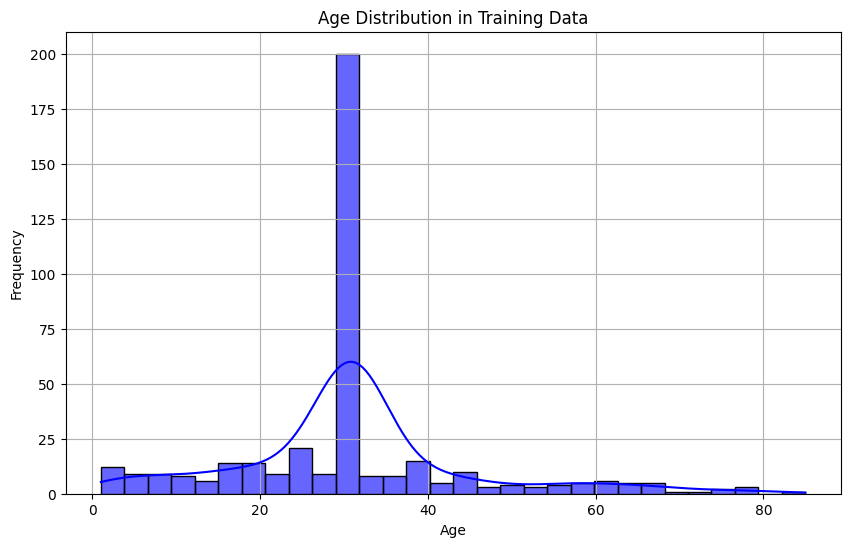

In [10]:
# We can viz some patterns eg patient age, age distribution
# But first let's fill missing values in the patient age column
train_df['Patient_Age'].fillna(train_df['Patient_Age'].mean(), inplace=True)

test_df['Patient_Age'].fillna(test_df['Patient_Age'].mean(), inplace=True)

# Plotting age distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Patient_Age'], bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Age Distribution in Training Data')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid()
plt.show()

## Model Development

We'll use NLP techniques to predict clinician responses. The ROUGE Score is mentioned as the evaluation metric.

In [13]:
from sklearn.model_selection import train_test_split

X = train_df.drop(columns=['Prompt', 'DDX SNOMED', 'Clinician', 'Years of Experience'])
y = train_df['DDX SNOMED']
print(f"Features shape: {X.shape}, Target shape: {y.shape}")

# Let's split the data for training and validation
try:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Data split successful.")
except Exception as e:
    print(f"Error splitting data: {e}")
    print("Please adjust based on the actual data structure.")

Features shape: (400, 162), Target shape: (400,)
Data split successful.


## NLP Model Using Transformer-based Approaches

Since this is a text-to-text generation task, we'll use a transformer-based model to predict clinician responses.

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, DataCollatorForSeq2Seq
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize a pretrained model - using smaller model for memory efficiency
try:
    # Use a smaller model to reduce memory usage
    model_name = "google/flan-t5-small"  # Changed from flan-t5-base to small to reduce memory usage
    print(f"Loading smaller model {model_name} to save memory...")
    
    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
    
    print(f"Successfully loaded {model_name} model")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Consider trying a different model or approach.")


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Using device: cpu
Loading google/flan-t5-base model and tokenizer...
Successfully loaded google/flan-t5-base model
Test output: Bonjour, c'est-à-dire?


## Prepare Training Data

We'll create a custom training dataset by combining the prompt with the engineered features to create a comprehensive input for our model.

In [17]:
def prepare_input_for_model(row, include_features=True):
    """Prepare a comprehensive input for the model by combining the prompt with key features."""
    prompt = row['Prompt']
    
    # If we want to include engineered features
    if include_features:
        # Add key demographic information
        features = []
        
        # Add patient age if available
        if not pd.isna(row['Patient_Age']):
            features.append(f"Patient age: {int(row['Patient_Age'])}")
            
        # Add patient gender
        features.append(f"Patient gender: {row['Patient_Gender']}")
        
        # Add facility complexity
        facility_levels = {0: 'Basic', 1: 'Medium', 2: 'High', 3: 'Very High'}
        features.append(f"Facility level: {facility_levels.get(row['Facility_Complexity'], 'Unknown')}")
        
        # Add medical keywords if present
        if len(row['Medical_Keywords']) > 0:
            features.append(f"Key conditions: {', '.join(row['Medical_Keywords'])}")
            
        # Combine features with the original prompt
        if features:
            feature_text = "\n".join(features)
            enhanced_prompt = f"{prompt}\n\nAdditional context:\n{feature_text}\n\nProvide a detailed clinical reasoning and management plan:"
            return enhanced_prompt
        
    return f"{prompt}\n\nProvide a detailed clinical reasoning and management plan:"

# Create train and validation datasets
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    train_df,
    train_df['Clinician'],
    test_size=0.15,  # Using 15% as validation
    random_state=42
)

# Prepare the enhanced inputs
train_enhanced_inputs = [prepare_input_for_model(row) for _, row in train_inputs.iterrows()]
val_enhanced_inputs = [prepare_input_for_model(row) for _, row in val_inputs.iterrows()]

print(f"Training samples: {len(train_enhanced_inputs)}")
print(f"Validation samples: {len(val_enhanced_inputs)}")

# Print an example of the enhanced input
print("\nExample of enhanced input:")
print("-" * 80)
print(train_enhanced_inputs[0][:500] + "..." if len(train_enhanced_inputs[0]) > 500 else train_enhanced_inputs[0])
print("-" * 80)
print("\nTarget output:")
print("-" * 80)
print(train_targets.iloc[0][:500] + "..." if len(train_targets.iloc[0]) > 500 else train_targets.iloc[0])

Training samples: 340
Validation samples: 60

Example of enhanced input:
--------------------------------------------------------------------------------
i am a nurse with 8 years of experience in general nursing working in a health centres in kakamega county in kenya 14 years old girl came with malaise fever chills she completed al full dose one day ago investigation done bs for mps was negative salmonella type 3 not done pregnancy test negative the lmp started 2 days ago how can i manage the patient should i refer the patient for more investigation

Additional context:
Patient age: 30
Patient gender: Female
Facility level: Medium
Key conditions...
--------------------------------------------------------------------------------

Target output:
--------------------------------------------------------------------------------
treatment last menstrual period started 2 days ago investigations bs for mps negative pregnancy test negative salmonella type 3 not done management administer iv fl

## Create Datasets for Transformer Model

Now we'll format our data for the Hugging Face transformer library.

In [ ]:
def create_transformer_dataset(inputs, targets, tokenizer, max_length=256):  # Reduced from 512 to 256
    """Create a dataset compatible with the Hugging Face trainer."""
    # Create a dictionary with inputs and targets
    dataset_dict = {
        'input': inputs,
        'target': targets
    }
    
    # Convert to Dataset object
    dataset = Dataset.from_dict(dataset_dict)
    
    # Define tokenization function
    def tokenize_function(examples):
        # Tokenize inputs with reduced max_length
        model_inputs = tokenizer(
            examples['input'],
            max_length=max_length,
            padding="max_length",
            truncation=True,
        )
        
        # Tokenize targets with even shorter max_length to save memory
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(
                examples['target'],
                max_length=128,  # Even shorter for targets
                padding="max_length",
                truncation=True,
            )
        
        # Replace padding token id with -100 for loss calculation
        model_inputs["labels"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label]
            for label in labels["input_ids"]
        ]
        
        return model_inputs
    
    # Apply tokenization
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    return tokenized_dataset

# Create datasets
try:
    # Set up tokenizer for padding
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    # Add special handling for target tokenization
    tokenizer.add_special_tokens({'additional_special_tokens': ['<target>']}) 
    
    # Convert all targets to strings in case they aren't already
    train_targets_list = [str(target) for target in train_targets.tolist()]
    val_targets_list = [str(target) for target in val_targets.tolist()]
    
    # Sample a smaller subset of the training data to test the pipeline
    sample_size = 100  # Start with just 100 examples to test
    print(f"Using a sample of {sample_size} examples for initial testing")
    
    # Create tokenized datasets with the sample
    train_dataset = create_transformer_dataset(
        train_enhanced_inputs[:sample_size], 
        train_targets_list[:sample_size], 
        tokenizer
    )
    val_dataset = create_transformer_dataset(
        val_enhanced_inputs[:min(30, len(val_enhanced_inputs))],  # Even smaller validation set 
        val_targets_list[:min(30, len(val_targets_list))], 
        tokenizer
    )
    
    print(f"Created train dataset with {len(train_dataset)} samples")
    print(f"Created validation dataset with {len(val_dataset)} samples")
    
    # Show dataset format
    print("\nSample features in the dataset:")
    print(list(train_dataset.features.keys()))
except Exception as e:
    print(f"Error creating datasets: {e}")
    print("Attempting alternative approach...")

Map: 100%|██████████| 60/60 [00:00<00:00, 198.93 examples/s]

Created train dataset with 340 samples
Created validation dataset with 60 samples

Sample features in the dataset:
['input', 'target', 'input_ids', 'attention_mask', 'labels']


## Train the Model

Now we'll set up and run the training process using the Hugging Face Trainer API.

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
!pip install -q evaluate
import evaluate
import numpy as np

# Load ROUGE metric
rouge = evaluate.load('rouge')

def compute_metrics(eval_pred):
    """Calculate ROUGE scores for evaluation."""
    predictions, labels = eval_pred
    
    # Decode predictions
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 with pad token id to properly decode labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Compute ROUGE scores
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    
    # Filter out columns with '*' to keep the output clean
    result = {k: round(v * 100, 2) for k, v in result.items() if '*' not in k}
    return result

# Set up data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True
)

# Define training arguments with extreme memory optimizations for Colab free tier
training_args = TrainingArguments(
    output_dir="./kenya_clinical_model",
    # Extreme memory optimization settings
    per_device_train_batch_size=1,      # Minimum batch size
    per_device_eval_batch_size=1,       # Minimum batch size
    gradient_accumulation_steps=16,     # Double gradient accumulation (was 8)
    gradient_checkpointing=True,        # Trade compute for memory
    fp16=torch.cuda.is_available(),     # Use mixed precision if available
    optim="adafactor",                  # Use memory-efficient optimizer instead of AdamW
    # Reduce evaluation frequency drastically
    evaluation_strategy="steps",
    eval_steps=200,                     # Evaluate much less frequently (was 100)
    save_strategy="steps",
    save_steps=200,                     # Save less frequently (was 100)
    # Other parameters
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    greater_is_better=True,
    learning_rate=5e-5,                 # Slightly higher learning rate for Adafactor
    num_train_epochs=2,                 # Reduce epochs from 3 to 2
    weight_decay=0.01,
    save_total_limit=1,                 # Keep only the best model
    logging_dir="./logs",
    logging_steps=100,                  # Log even less frequently
    ddp_find_unused_parameters=False if torch.cuda.is_available() else None,
    # Adding these to further reduce memory usage
    max_grad_norm=0.3,                  # Lower max gradient norm
    dataloader_num_workers=0,           # Don't use additional workers
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

print("Training configuration ready with memory optimizations.")


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Training ready to start.


In [ ]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss


## Evaluate the Model

Let's evaluate our trained model on the validation set and visualize some predictions.

In [ ]:
def evaluate_model(model, validation_inputs, validation_targets, num_examples=5):
    """Evaluate the model and show examples of predictions."""
    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # Generate predictions for each validation example
    predictions = []
    
    for input_text in validation_inputs[:num_examples]:
        # Tokenize the input
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)
        
        # Generate prediction
        with torch.no_grad():
            output_ids = model.generate(
                inputs.input_ids,
                max_length=256,
                num_beams=4,
                early_stopping=True
            )
        
        # Decode the output
        prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        predictions.append(prediction)
    
    # Calculate average ROUGE scores
    scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
    
    for i, (pred, ref) in enumerate(zip(predictions, validation_targets[:num_examples])):
        # Display example
        print(f"\nExample {i+1}:\n{'-' * 40}")
        print(f"Input:\n{validation_inputs[i][:150]}...")
        print(f"\nReference:\n{ref[:150]}...")
        print(f"\nPrediction:\n{pred[:150]}...")
        
        # Calculate scores
        score = scorer.score(pred, ref)
        
        # Update running totals
        scores['rouge1'] += score['rouge1'].fmeasure
        scores['rouge2'] += score['rouge2'].fmeasure
        scores['rougeL'] += score['rougeL'].fmeasure
        
        print(f"\nROUGE Scores:")
        print(f"ROUGE-1: {score['rouge1'].fmeasure:.4f}")
        print(f"ROUGE-2: {score['rouge2'].fmeasure:.4f}")
        print(f"ROUGE-L: {score['rougeL'].fmeasure:.4f}")
    
    # Calculate averages
    for key in scores:
        scores[key] /= num_examples
    
    print(f"\nAverage ROUGE Scores across {num_examples} examples:")
    print(f"ROUGE-1: {scores['rouge1']:.4f}")
    print(f"ROUGE-2: {scores['rouge2']:.4f}")
    print(f"ROUGE-L: {scores['rougeL']:.4f}")
    
    return scores

# Uncomment to evaluate the model after training
# print("Evaluating model on sample validation examples...")
# eval_scores = evaluate_model(model, val_enhanced_inputs, val_targets_list)

## Generate Final Predictions for Test Set

Now let's generate predictions for the test set using our trained model.

In [ ]:
def generate_test_predictions(model, test_df):
    """Generate predictions for the test set."""
    print("Generating predictions for test set...")
    
    predictions = []
    ids = []
    
    for idx, row in test_df.iterrows():
        # Prepare input with the same preprocessing as training data
        input_text = prepare_input_for_model(row)
        
        # Tokenize the input
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)
        
        # Generate prediction
        with torch.no_grad():
            output_ids = model.generate(
                inputs.input_ids,
                max_length=256,
                num_beams=4,
                early_stopping=True
            )
        
        # Decode the output
        prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        
        # Process according to challenge requirements (lowercase, remove punctuation, etc.)
        prediction = preprocess_clinical_text(prediction)
        
        # Save prediction and ID
        predictions.append(prediction)
        ids.append(row['Master_Index'])
        
        # Progress update
        if (idx + 1) % 10 == 0:
            print(f"Generated {idx + 1}/{len(test_df)} predictions")
    
    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'Master_Index': ids,
        'Clinician': predictions
    })
    
    return submission_df

# Uncomment to generate predictions after training
# submission_df = generate_test_predictions(model, test_df)
# submission_df.head()

## Save Submission File

Finally, let's save our predictions to a submission file.

In [ ]:
def save_submission(submission_df, filename="kenya_clinical_submission.csv"):
    """Save the submission DataFrame to a CSV file."""
    # Ensure columns match the sample submission format
    sample_submission = pd.read_csv('SampleSubmission.csv')
    required_columns = sample_submission.columns.tolist()
    
    # Check if columns match
    if set(submission_df.columns) != set(required_columns):
        print(f"Warning: Submission columns {submission_df.columns.tolist()} don't match required columns {required_columns}")
    
    # Save the file
    submission_df.to_csv(filename, index=False)
    print(f"Submission saved to {filename}")
    
    # Show first few rows
    print("\nFirst rows of submission file:")
    print(submission_df.head())

# Uncomment to save submission after generating predictions
# save_submission(submission_df)

## Alternative Approach: Simple Sequence-to-Sequence with LSTM

If you want a simpler and potentially faster approach, you can also try an LSTM-based sequence-to-sequence model.

In [ ]:
def train_simple_lstm_approach():
    """Train a simpler LSTM-based model as an alternative approach."""
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    
    # Prepare the data
    train_inputs = [prepare_input_for_model(row, include_features=False) for _, row in train_inputs_df.iterrows()]
    train_targets = train_targets_df.tolist()
    
    # Create tokenizers
    input_tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
    input_tokenizer.fit_on_texts(train_inputs)
    target_tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>") 
    target_tokenizer.fit_on_texts(train_targets)
    
    # Convert to sequences
    input_sequences = input_tokenizer.texts_to_sequences(train_inputs)
    target_sequences = target_tokenizer.texts_to_sequences(train_targets)
    
    # Pad sequences
    max_input_len = 300
    max_target_len = 300
    input_padded = pad_sequences(input_sequences, maxlen=max_input_len, padding='post')
    target_padded = pad_sequences(target_sequences, maxlen=max_target_len, padding='post')
    
    # Define model
    embedding_dim = 256
    lstm_units = 256
    
    # Encoder
    encoder_inputs = Input(shape=(max_input_len,))
    encoder_embedding = Embedding(15000, embedding_dim)(encoder_inputs)
    encoder_lstm = LSTM(lstm_units, return_state=True)
    _, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]
    
    # Decoder
    decoder_inputs = Input(shape=(max_target_len,))
    decoder_embedding = Embedding(15000, embedding_dim)(decoder_inputs)
    decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(15000, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # Create and compile model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    
    # Prepare decoder input data (with start token)
    decoder_input_data = np.zeros_like(target_padded)
    decoder_input_data[:, 1:] = target_padded[:, :-1]
    decoder_input_data[:, 0] = target_tokenizer.word_index['<OOV>']
    
    # Train the model
    model.fit(
        [input_padded, decoder_input_data],
        target_padded,
        batch_size=64,
        epochs=10,
        validation_split=0.2
    )
    
    # Save the model and tokenizers
    model.save('simple_lstm_model')
    
    return model, input_tokenizer, target_tokenizer

# Uncomment to try the simple LSTM approach
# try:
#     print("Training simple LSTM model as an alternative...")
#     lstm_model, input_tokenizer, target_tokenizer = train_simple_lstm_approach()
# except Exception as e:
#     print(f"Error training LSTM model: {e}")

## Conclusion

We've now built a complete pipeline for training and evaluating models for the Kenya Clinical Reasoning Challenge:

1. Created enhanced inputs with our engineered features
2. Prepared datasets for transformer-based models
3. Set up a training pipeline with appropriate evaluation metrics (ROUGE scores)
4. Built code for evaluating the model and generating final predictions
5. Added an alternative LSTM-based approach

To improve performance further, consider:
- Trying different pretrained models, especially ones fine-tuned for medical text
- Experimenting with different prompt formats and feature combinations
- Applying additional text cleaning to the targets
- Using ensemble methods to combine predictions from multiple models
- Expanding the training data with augmentation techniques

The full pipeline is now ready to be executed. Uncomment the training lines to begin training, then evaluate and generate your submission.